In [ ]:
#import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
import copy
import os
import re
import seaborn as sns
import stylecloud
from konlpy.tag import Okt
from collections import Counter
from IPython.display import Image
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

# 함수 정의

In [ ]:

#단어 전처리 함수
def Preprocessing(text): 
    result = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]", " ", text).strip()
    result = result.lower()
    return result
    
#Okt 형태소 분석기를 이용한 Tokenization 함수
def OktDecompose(row, okt, stopwords):

    if len(row) == 0:
        return ''
    temp_X = okt.morphs(row, norm=True, stem=True) #정규화와 어간 추출

    temp_X = [word for word in temp_X if not word in stopwords]
    
    # '주린이'라는 단어가 '주리다'로 분석되는 현상 수정
    if '주리다' in temp_X:
        temp_X[temp_X.index('주리다')] = '주린이'
        
        
    return temp_X



def WordCount(row):
    wordcount = Counter()
    words, weight = row[0], row[1]
    
    for word in words:
        wordcount.update({word : weight})
    
    return wordcount


#KDC(한국 십진분류체계) 코드를 한글로 변환
def Classification(row):
    
    if row == 0:
        return '총류'
    
    elif row == 1:
        return '지식 및 학문 일반'
    elif row == 3:
        return '이론 체계 및 시스템'
    elif row == 4:
        return '컴퓨터과학'
    elif row == 5:
        return '프로그래밍'
    
    elif 10 <= row < 20:
        return '도서학'
    elif 20 <= row < 30:
        return '문헌정보학'
    elif 30 <= row < 40:
        return '백과사전'
    elif 40 <= row < 50:
        return '강연집 및 수필'
    elif 50 <= row < 60:
        return '일반연속간행물'
    elif 60 <= row < 70:
        return '학회 및 기관지'
    elif 70 <= row < 80:
        return '신물 및 저널리즘'
    elif 80 <= row < 90:
        return '일반 전집 및 총서'
    
    elif 90 <= row < 100:
        return '향토자료'
    
    elif 100 <= row < 200:
        return '철학'
    
    elif 200 <= row < 300:
        return '종교'
    
    elif 300 <= row < 310:
        return '사회과학'
    elif 310 <= row < 320:
        return '통계자료'
    elif 320 <= row < 330:
        return '경제학'
    elif 330 <= row < 340:
        return '사회학 및 사회문제'
    elif 340 <= row < 250:
        return '정치학'
    elif 350 <= row < 360:
        return '행정학'
    elif 360 <= row < 370:
        return '법률'
    elif 370 <= row < 380:
        return '교육학'
    elif 380 <= row < 390:
        return '풍습, 예절, 민속'
    elif 390 <= row < 400:
        return '국방 및 군사'
    elif 400 <= row < 500:
        return '자연과학'
    
    elif 500 <= row < 510:
        return '기술과학'
    elif 510 <= row < 520:
        return '의학'
    elif 520 <= row < 530:
        return '농업'
    elif 530 <= row < 540:
        return '공학 및 토목'
    elif 540 <= row < 550:
        return '건축'
    elif 550 <= row < 560:
        return '기계공학'
    elif 560 <= row <570:
        return '전기전자공학'
    elif 570 <= row < 580:
        return '화학공학'
    elif 580 <= row < 590:
        return '제조업'
    elif 590 <= row < 600:
        return '생활과학'
    
    elif 600 <= row < 700:
        return '예술'
    
    elif 700 <= row < 740:
        return '비영어 언어'
    elif 740 <= row < 750:
        return '영어'
    elif 750 <= row < 800:
        return '비영어 언어'
    
    elif 800 <= row < 900:
        return '문학'
    elif 900 <= row < 1000:
        return '역사'


#Pie chart 표기 함수
def text(value):
    
    if value < 3:
        return ''
    
    return '%.1f'%(value /100 * 631.6017851829)


def DIFF(row):
    a = dt.datetime(int(row[1][:4]), int(row[1][4:]), 15)- dt.datetime(int(row[0][:4]), int(row[0][4:6]), int(row[0][6:]))
    return a.days


def DIFF1(row, data):
    a = data['도서명'].apply(lambda x : x == row)

    if a.sum() > 0 :
        return True 
    else:
        return False

# 데이터 통합

- 2019년 01월부터 2021년 03월까지의 교보문고 월간 베스트셀러 데이터를 통합하고 전처리한다.


- 2019년 01월부터 2021년 03월까지의 대한출판문화협회 신간 도서 목록 데이터를 통합하고 전처리한다.


- 전처리를 마친 완성 데이터셋을 따로 첨부했으므로, 이 코드는 돌리지 않으셔도 됩니다.

    - 혹여나 돌리시는 경우, 자신의 컴퓨터 환경에 맞는 path 지정이 필요합니다.

# 1. 2018년 이전에 출판된 책 중에 코로나 이후 베스트셀러가 된 책은 무엇일까?

In [ ]:
data = pd.read_excel('Best_Seller.xlsx')
data['작성연월'] = data['작성연월'].apply(lambda row : str(row))
data['가중치'] = data['가중치'].apply(lambda row : float(row))
data['출간일'] = data['출간일'].apply(lambda row : str(row))
print("총 Rows 수 : ", len(data))
del data['Unnamed: 0']
data.head()

총 Rows 수 :  5399


,순위,ISBN,도서명,저자명,출판사명,출간일,분야,정가,작성연월,코로나,가중치
0,1,9791187498384,고요할수록 밝아지는 것들,혜민 스님,수오서재,20181206,시/에세이,15000,201901,코로나 이전,7.243582
1,2,9788959895526,트렌드 코리아 2019,김난도,미래의창,20181026,경제/경영,17000,201901,코로나 이전,7.171863
2,3,9788984373617,아가씨와 밤,기욤 뮈소,밝은세상,20181126,소설,14500,201901,코로나 이전,7.100855
3,4,9791187119845,나는 나로 살기로 했다,김수현,마음의숲,20200316,시/에세이,13800,201901,코로나 이전,7.030549
4,5,9788925563350,"곰돌이 푸, 행복한 일은 매일 있어",곰돌이 푸 (원작),알에이치코리아,20180312,시/에세이,12000,201901,코로나 이전,6.960940


In [ ]:
a = data[(data['출간일'] < '20190000') & (data['코로나'] == '코로나 이후')]

b = data[(data['출간일'] < '20190000')  & (data['코로나'] == '코로나 이전')]

temp = a[a['도서명'].apply(lambda row : row in list(set(a['도서명']) - set(b['도서명'])))]
temp = temp.groupby('분야')['가중치'].sum().sort_values(ascending=False).to_frame().T
temp

분야,소설,정치/사회,경제/경영,어린이(초등),자기계발,인문,유아(0~7세),청소년,시/에세이,여행,외국어,과학,예술/대중문화,건강
가중치,111.274171,44.461624,32.602621,24.914721,23.500272,14.294162,13.792446,13.133905,10.438172,6.266144,4.083637,2.653227,1.361327,1.282432


- 2019년 이전에 출판된 도서 중, 코로나 이전에는 베스트 셀러에 등재되지 못하다가 코로나 이후 읽히기 시작한 도서를 분야별로 그 가중치를 더하였다.



- 소설이 가장 두두러진 경향성을 보이는데, 이는 소설 같은 경우는 시기에 구애받지 않고 오래된 책이라도 많이 읽힌다는 의미이다.


- 반면 다른 분야의 책들은 그 시기의 트렌드나 유행에 반응하는 경향이 있어서 시간이 지나면 자연스레 읽히지 않는 양상을 보인다.


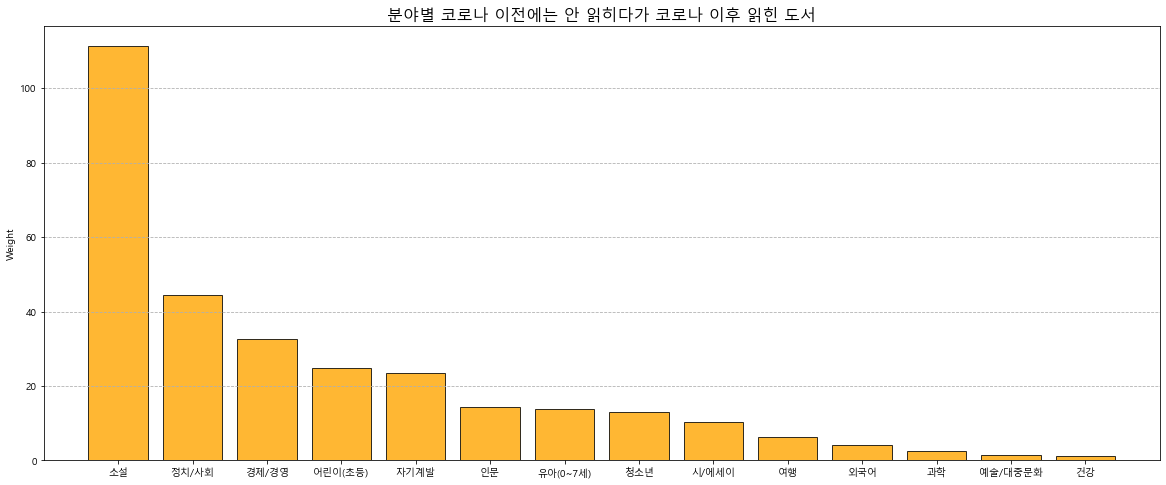

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(temp.columns, temp.loc['가중치'], edgecolor='k', color='orange', alpha=0.8)
ax.set_ylabel('Weight')
ax.set_xlim(-1, 14)
ax.grid(axis='y', ls='--')
ax.set_title('분야별 코로나 이전에는 안 읽히다가 코로나 이후 읽힌 도서', fontsize=16);

In [ ]:
#소설 제외
a = data[(data['출간일'] < '20190000') & (~data['분야'].str.contains('소설|청소년|외국어', regex=True)) & (data['코로나'] == '코로나 이후')]

b = data[(data['출간일'] < '20190000') & (~data['분야'].str.contains('소설|청소년|외국어', regex=True)) & (data['코로나'] == '코로나 이전')]

temp = a[a['도서명'].apply(lambda row : row in list(set(a['도서명']) - set(b['도서명'])))]
temp = temp.drop_duplicates(['도서명', '출간일', '분야']).reset_index(drop=True)[['도서명', '저자명', '출간일', '분야']]
temp

,도서명,저자명,출간일,분야
0,"돈, 뜨겁게 사랑하고 차갑게 다루어라(코스톨라니 투자총서 1)",앙드레 코스톨라니,20150930,경제/경영
1,미라클모닝,할 엘로드,20160222,자기계발
2,오무라이스 잼잼: 함께 완성하는 컬러링북,조경규,20160516,예술/대중문화
3,왜 세계의 절반은 굶주리는가?(개정증보판),장 지글러,20160321,정치/사회
4,위험한 과학책(양장본 HardCover),랜들 먼로,20150424,과학
5,JUSTICE 정의란 무엇인가(10대를 위한),마이클 샌델,20141130,어린이(초등)
6,지리의 힘,팀 마샬,20160810,정치/사회
7,달 샤베트(그림책이 참 좋아 19),백희나,20140610,유아(0~7세)
8,장수탕 선녀님(책 읽는 곰 7)(양장본 HardCover),백희나,20120824,유아(0~7세)
9,열두 살에 부자가 된 키라(꿈을 이루게 도와주는 자기경영 동화 1)(양장본 Hard...,보도 섀퍼,20141023,어린이(초등)


# 2번 코로나 이후로 어느 분야의 도서 판매량이 증가 혹은 감소했을까?

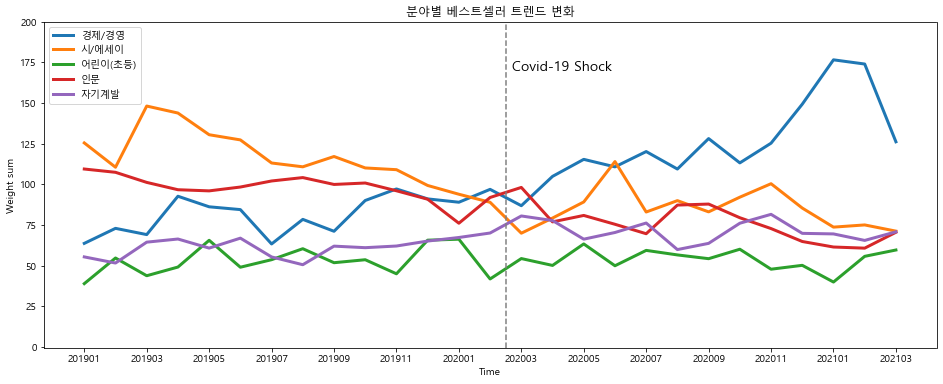

In [ ]:
temp = data[data['분야'].str.contains('경제|자기계발|어린이|에세이|인문',regex=True)]
pivot = pd.pivot_table(temp, index='작성연월', columns='분야', values='가중치', aggfunc='sum').fillna(0)
fig, ax = plt.subplots(figsize=(16, 6))
dates = list(pivot.index)
for col in pivot.columns:
    ax.plot(dates, pivot[col], lw=3, label=col);
ax.axvline(13.5, color='gray', ls='--')
ax.text(13.7, 170, 'Covid-19 Shock', fontsize=14)
ax.set_xticks(['201901', '201903', '201905', '201907', '201909', '201911', '202001', '202003', '202005', '202007', '202009',
                    '202011', '202101', '202103'])
ax.legend(loc='upper left')
ax.set_ylim(-0.5, 200)
ax.set_title('분야별 베스트셀러 트렌드 변화')
ax.set_xlabel('Time')
ax.set_ylabel('Weight sum');

In [ ]:
temp = data.groupby(['작성연월', '분야'])['가중치'].sum().to_frame()
columns=['작성연월', '분야', '가중치', '코로나']
df = pd.DataFrame(columns=columns)

for (i, j), k in temp.iterrows():
    
    if i < '202003':
        corona = 0
    else:
        corona = 1
    df = df.append(pd.Series([i, j, k.item(), corona], index=columns), ignore_index=True)
    
del temp
temp = copy.deepcopy(df[(df['분야'] == '자기계발') | (df['분야'] == '어린이(초등)')])

temp['자기계발'] = np.where(temp['분야'] == '자기계발', 1, 0)
temp['코로나 x 자기계발'] = temp['코로나'] * temp['자기계발']
temp['Time'] = [int(i) for i in np.arange(1, 28, 0.5)]
temp.reset_index(drop=True, inplace=True)
temp.head()

,작성연월,분야,가중치,코로나,자기계발,코로나 x 자기계발,Time
0,201901,어린이(초등),38.939115,0,0,0,1
1,201901,자기계발,55.380063,0,1,0,1
2,201902,어린이(초등),54.701771,0,0,0,2
3,201902,자기계발,51.607983,0,1,0,2
4,201903,어린이(초등),43.800972,0,0,0,3


In [ ]:
X = temp[(temp['분야'] == '자기계발') & (temp['작성연월'] < '202003')]['Time'].astype(np.float32)
X = sm.add_constant(X)
y = temp[(temp['분야'] == '자기계발') & (temp['작성연월'] < '202003')]['가중치']
res = sm.OLS(y, X, missing='drop').fit()
trend_line1 = res.params[0] + res.params[1] * temp[(temp['분야'] == '자기계발') & (temp['작성연월'] < '202003')]['Time']

self_dev_result = res

X = temp[(temp['분야'] == '어린이(초등)') & (temp['작성연월'] < '202003')]['Time'].astype(np.float32)
X = sm.add_constant(X)
y = temp[(temp['분야'] == '어린이(초등)') & (temp['작성연월'] < '202003')]['가중치']
res = sm.OLS(y, X, missing='drop').fit()
trend_line2 = res.params[0] + res.params[1] * temp[(temp['분야'] == '어린이(초등)') & (temp['작성연월'] < '202003')]['Time']

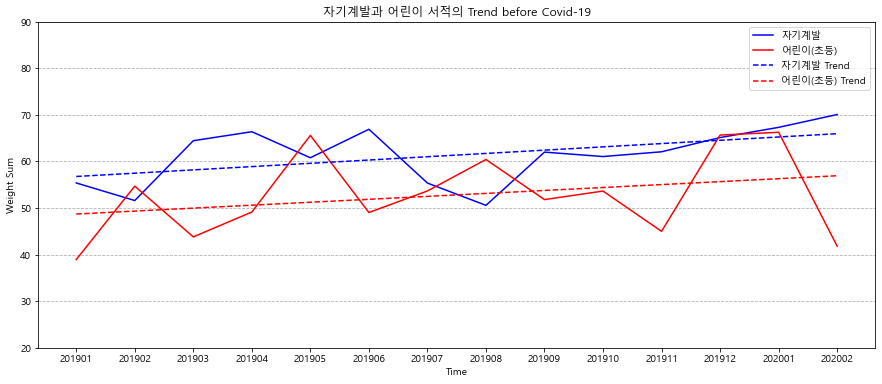

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
dates = temp[(temp['분야'] == '자기계발') & (temp['작성연월'] < '202003')]['작성연월']
weight1 = temp[(temp['분야'] == '자기계발') & (temp['작성연월'] < '202003')]['가중치']
weight2 = temp[(temp['분야'] == '어린이(초등)') & (temp['작성연월'] < '202003')]['가중치']
ax.set_ylim(20, 90)
ax.plot(dates, weight1, 'b', label='자기계발')
ax.plot(dates, weight2, 'r', label='어린이(초등)')
ax.plot(dates, trend_line1, 'b--', label='자기계발 Trend')
ax.plot(dates, trend_line2, 'r--', label='어린이(초등) Trend')
ax.legend()
ax.grid(axis='y', ls='--')
ax.set_xlabel('Time')
ax.set_ylabel('Weight Sum')
ax.set_title('자기계발과 어린이 서적의 Trend before Covid-19');


In [ ]:
X = temp[['코로나', '자기계발', '코로나 x 자기계발']].astype(np.float32)
X = sm.add_constant(X)
y = temp['가중치']
res = sm.OLS(y, X, missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    가중치   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     19.06
Date:                Thu, 27 May 2021   Prob (F-statistic):           2.24e-08
Time:                        00:58:43   Log-Likelihood:                -180.60
No. Observations:                  54   AIC:                             369.2
Df Residuals:                      50   BIC:                             377.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.8180      1.905     27.725      0.000      48.992      56.644
코로나            1.1366      2.746      0.414      0.681      -4.378       6.651
자기계발           8.5419      2.694      3.170      0.003       3.130      13.953
코로나 x 자기계발     8.8878      3.883      2.289      0.026       1.089      16.686
==============================================================================
Omnibus:                        1.182   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                0.994
Skew:                          -0.080   Prob(JB):                        0.608
Kurtosis:                       2.355   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

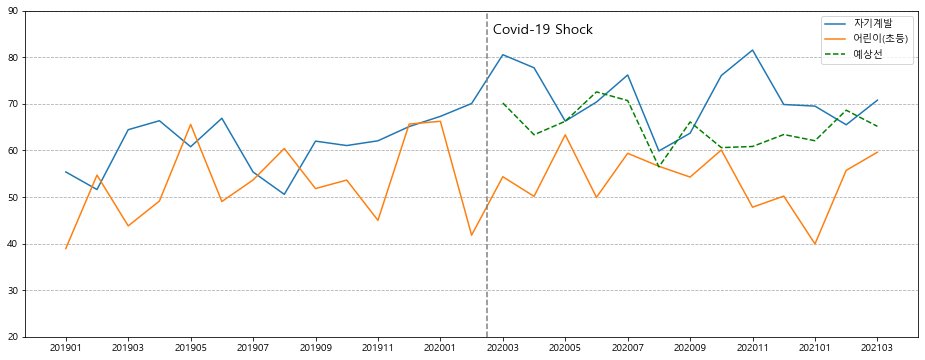

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
dates = temp[(temp['분야'] == '자기계발')]['작성연월']
weight1 = temp[(temp['분야'] == '자기계발')]['가중치']
weight2 = temp[(temp['분야'] == '어린이(초등)')]['가중치']
ax.plot(dates, weight1, label='자기계발')
ax.plot(dates, weight2, label='어린이(초등)')
ax.set_ylim(20, 90)
ax.axvline(13.5, color='gray', ls='--')
ax.text(13.7, 85, 'Covid-19 Shock', fontsize=14)
ax.set_xticks(['201901', '201903', '201905', '201907', '201909', '201911', '202001', '202003', '202005', '202007', '202009',
                    '202011', '202101', '202103'])
ax.grid(axis='y', ls='--')
predicted_line = res.params[0] +  res.params[2]\
                 + np.random.RandomState(0).normal(loc=0, scale=5, size=(13,))
ax.plot(temp[(temp['분야'] == '자기계발') & (temp['작성연월'] > '202002')]['작성연월'],
        predicted_line, color='green', ls='--', label='예상선');
ax.legend();

In [ ]:
temp = data[data['분야'].str.contains('경제|어린이|자기계발|인문|에세이', regex=True)]
pivot = pd.pivot_table(temp, index='작성연월', columns='분야', values='가중치', aggfunc='sum').fillna(0)
pivot[['경제/경영', '자기계발', '어린이(초등)', '인문', '시/에세이']].corr('pearson')

분야,경제/경영,자기계발,어린이(초등),인문,시/에세이
분야,,,,,
경제/경영,1.000000,0.449772,-0.039099,-0.893770,-0.665774
자기계발,0.449772,1.000000,-0.050044,-0.616622,-0.478068
어린이(초등),-0.039099,-0.050044,1.000000,-0.113376,-0.203769
인문,-0.893770,-0.616622,-0.113376,1.000000,0.667387
시/에세이,-0.665774,-0.478068,-0.203769,0.667387,1.000000


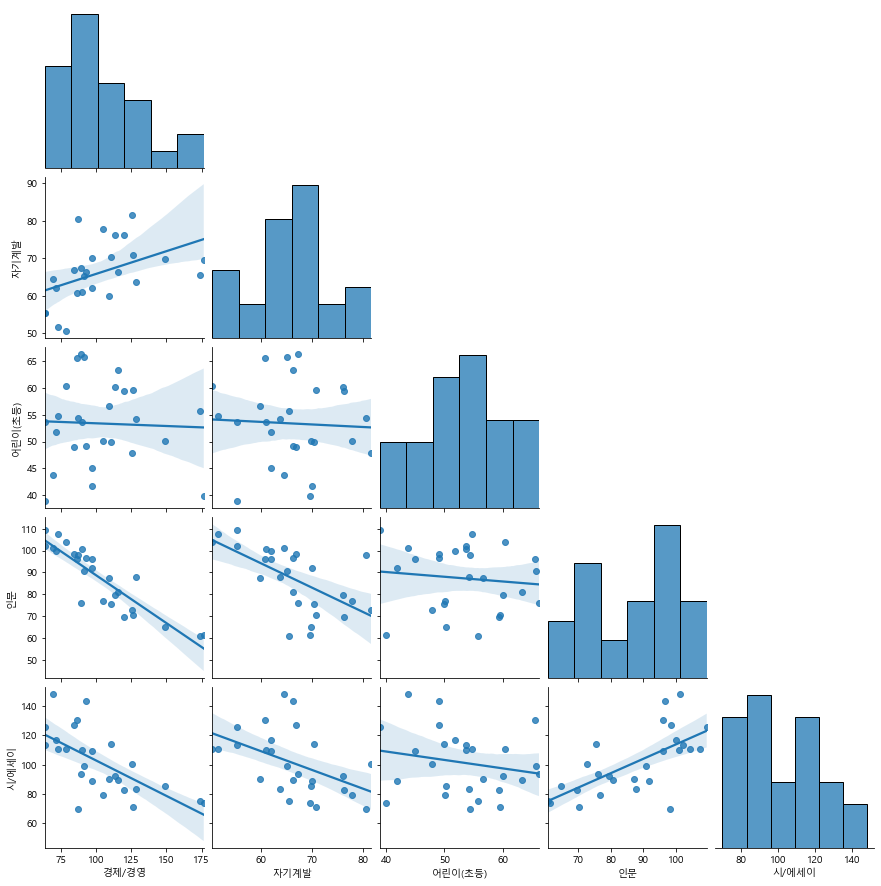

In [ ]:
sns.pairplot(pivot[['경제/경영', '자기계발', '어린이(초등)', '인문', '시/에세이']], kind='reg', corner=True);

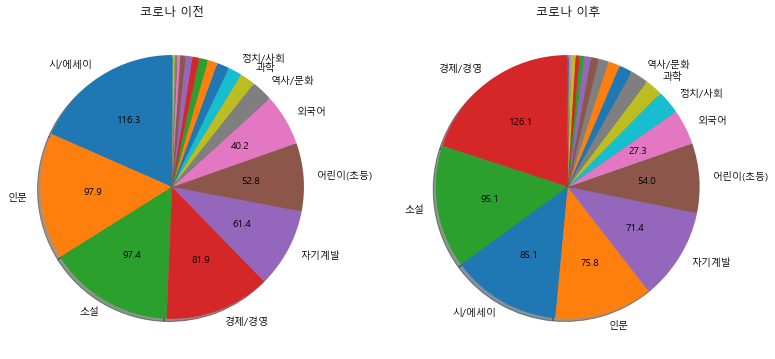

In [ ]:
temp = copy.deepcopy(data)
pivot = pd.pivot_table(temp, index='작성연월', columns='분야', values='가중치', aggfunc='sum').fillna(0)
pre_covid = pivot[pivot.index < '202003'].mean().sort_values(ascending=False)
post_covid = pivot[pivot.index >= '202003'].mean().sort_values(ascending=False)
color_map = dict([(c, f'C{i}') for i, c in enumerate(pre_covid.index)])

pre_covid = pre_covid.to_frame()
pre_covid.columns=['가중치']
pre_covid['color'] = pd.Series(color_map)

post_covid = post_covid.to_frame()
post_covid.columns=['가중치']
post_covid['color'] = pd.Series(color_map)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 15))

ax0.pie(pre_covid['가중치'], labels=list(pre_covid.index[:10]) + ['' for i in range(12)], startangle=90,
       colors=pre_covid['color'], autopct=text, shadow=True); #%.1f : formating,  %% : 끝부분에 %를 붙여라(%만 쓰면 포매팅으로 인식)
ax1.pie(post_covid['가중치'], labels=list(post_covid.index[:10]) + ['' for i in range(12)], startangle=90,
        colors=post_covid['color'], autopct=text, shadow=True)
ax0.set_title('코로나 이전')
ax1.set_title('코로나 이후');

# 3번 코로나 전후에 베스트셀러 제목에 노출된 Keyword에는 어떤 차이가 있을까?

In [ ]:
okt = Okt()
stopwords = ['은', '는', '이', '가', '요', '시', '로', '으로', '에게', '에', '을', '를', '것', '와', '과', '들',
             'hardcover', '양장본', '의', '에디', '션', '않다', '리', '개정판', '되다', '한', '보다', '만부', '판',
             '커버', '기념', '흔', '한정판', '더', '일', '위', '초', '살', '판본', 'edition', '수', '만', '년생', '년',
             '대', '싶다', '에서', '서', '편', '주년', '어', '전집', 'go', '가지', '사피', '엔', '스', '개정', '하다',
             '아', '오', '넌', '게', '고', '내', '없다', '어떻다', '권', '나', '나도', '살기', '아주', '론', '있다',
             '많다', '이야', '인', '셀프', '력', '때', '잘', '상위', '쇄', '이후', '시리즈', '지', '이다', '디', '넛',
             '이라', '앞', '되어다', '적', '애', '제', '경', '알', '면', '바로', '덕분', '법', '줄', '부터는', '때문',
             '분', '하고', '네', '너', '리지', '엉덩이', '무작정', '괜찮다', '읽다', '넓다', '널', '살인', '증보',
             '나르다', '남매', '따르다', '전', '방', '나로', '얕다']

In [ ]:
corpus = copy.deepcopy(data[['도서명', '가중치', '분야', '작성연월']])
corpus = corpus[~corpus['분야'].str.contains('소설|청소년|만화', regex=True)]
corpus['도서명'] = corpus['도서명'].apply(lambda row : Preprocessing(row))
corpus['도서명'] = corpus['도서명'].apply(lambda row : OktDecompose(row, okt, stopwords))
corpus.head()

,도서명,가중치,분야,작성연월
0,"[고요하다, 밝아지다]",7.243582,시/에세이,201901
1,"[트렌드, 코리아]",7.171863,경제/경영,201901
3,[],7.030549,시/에세이,201901
4,"[곰돌이, 푸다, 행복하다, 매일]",6.960940,시/에세이,201901
5,"[인생, 법칙]",6.892020,인문,201901


In [ ]:
corpus['도서명'] = corpus.apply(lambda row : WordCount(row), axis=1)
corpus['코로나'] = data['코로나']
corpus.head()

,도서명,가중치,분야,작성연월,코로나
0,"{'고요하다': 7.243582031514805, '밝아지다': 7.24358203...",7.243582,시/에세이,201901,코로나 이전
1,"{'트렌드': 7.171863397539411, '코리아': 7.1718633975...",7.171863,경제/경영,201901,코로나 이전
3,{},7.030549,시/에세이,201901,코로나 이전
4,"{'곰돌이': 6.960939955934635, '푸다': 6.96093995593...",6.960940,시/에세이,201901,코로나 이전
5,"{'인생': 6.892019758351124, '법칙': 6.892019758351...",6.892020,인문,201901,코로나 이전


In [ ]:
pre_corona = Counter()
pre_corona_corpus = corpus[corpus['코로나'] == '코로나 이전']
pre_corona_corpus['도서명'].apply(lambda row: pre_corona.update(row))

post_corona = Counter()
post_corona_corpus = corpus[corpus['코로나'] == '코로나 이후']
post_corona_corpus['도서명'].apply(lambda row: post_corona.update(row));


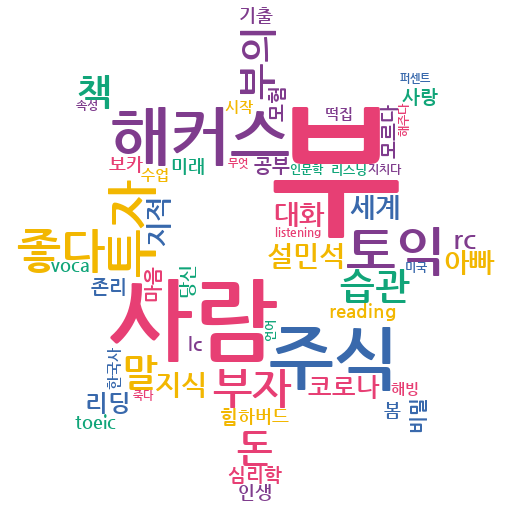

In [ ]:
stylecloud.gen_stylecloud(text=dict(post_corona.most_common(60)), icon_name="fas fa-virus",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='post_corona.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/post_corona.png")

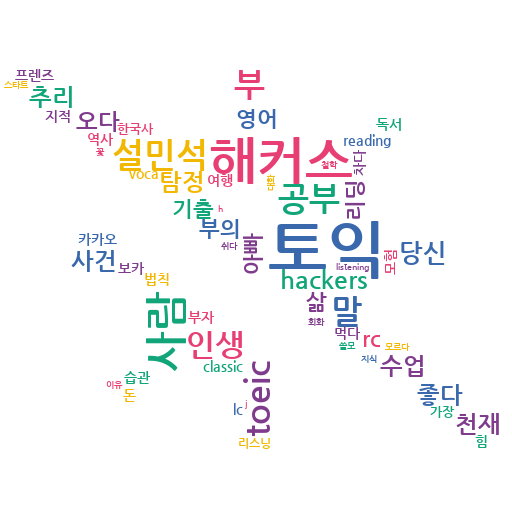

In [ ]:
stylecloud.gen_stylecloud(text=dict(pre_corona.most_common(60)), icon_name="fas fa-virus-slash",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='pre_corona.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/pre_corona.png")

In [ ]:
#코로나 이후 등장한 Keywords
set_A = set([a[0] for a in post_corona.most_common(100)])
set_B = set([a[0] for a in pre_corona.most_common(100)])

set_A - set_B

{'having',
 '가게',
 '강사',
 '공간',
 '구석',
 '균',
 '데일',
 '떠나다',
 '떡집',
 '무엇',
 '미국',
 '미래',
 '미술관',
 '보급',
 '봄',
 '비밀',
 '사경',
 '사랑',
 '사전',
 '속성',
 '쇠',
 '스타',
 '시작',
 '심리학',
 '어른',
 '영웅',
 '이네',
 '이상하다',
 '인가',
 '인간관계',
 '인문학',
 '재무제표',
 '절대로',
 '제로',
 '존리',
 '주식',
 '집',
 '차선',
 '착각',
 '책',
 '총',
 '추월',
 '카네기',
 '코로나',
 '코스모스',
 '태도',
 '투자',
 '퍼센트',
 '해빙',
 '해주다',
 '회계사',
 '흔하다'}

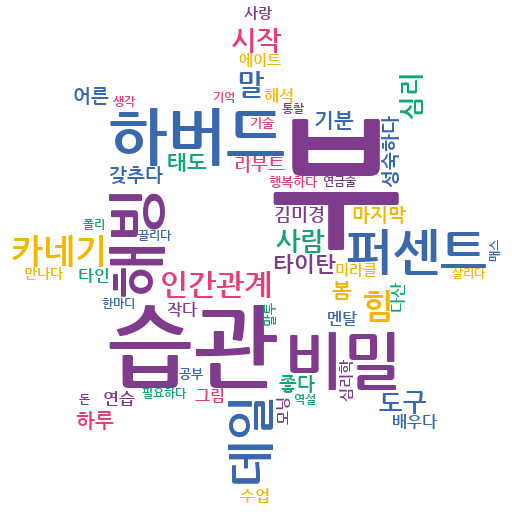

In [ ]:
post_corona_self_dev = Counter()
post_corona_self_dev_df = corpus[(corpus['코로나'] == '코로나 이후') & (corpus['분야'] == '자기계발')]
post_corona_self_dev_df['도서명'].apply(lambda row: post_corona_self_dev.update(row));

stylecloud.gen_stylecloud(text=dict(post_corona_self_dev.most_common(60)), icon_name="fas fa-virus",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='post_corona_self_dev.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/post_corona_self_dev.png")

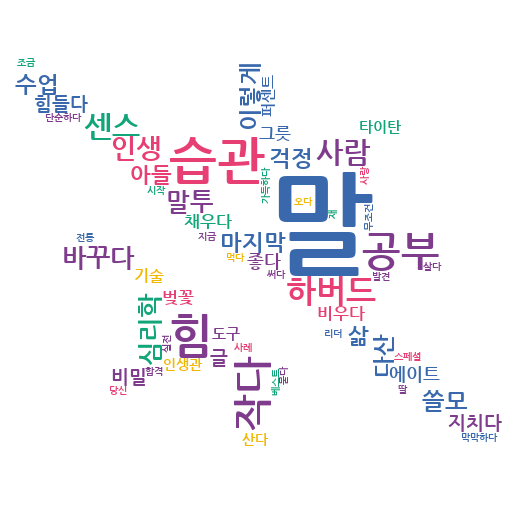

In [ ]:
pre_corona_self_dev = Counter()
pre_corona_self_dev_df = corpus[(corpus['코로나'] == '코로나 이전') & (corpus['분야'] == '자기계발')]
pre_corona_self_dev_df['도서명'].apply(lambda row: pre_corona_self_dev.update(row));

stylecloud.gen_stylecloud(text=dict(pre_corona_self_dev.most_common(60)), icon_name="fas fa-virus-slash",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='pre_corona_self_dev.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/pre_corona_self_dev.png")

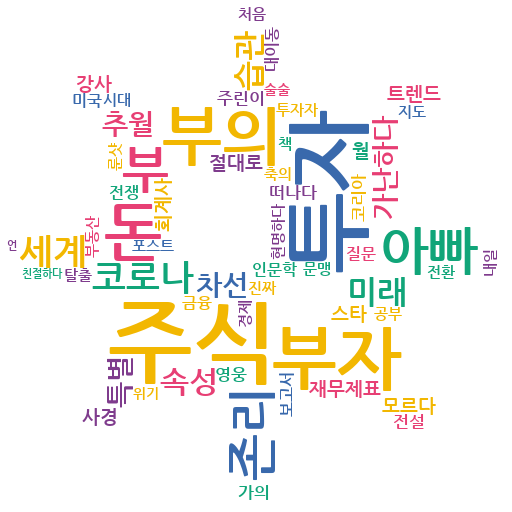

In [ ]:
post_corona_eco = Counter()
post_corona_eco_df = corpus[(corpus['코로나'] == '코로나 이후') & (corpus['분야'] == '경제/경영')]
post_corona_eco_df['도서명'].apply(lambda row: post_corona_eco.update(row));

stylecloud.gen_stylecloud(text=dict(post_corona_eco.most_common(60)), icon_name="fas fa-virus",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='post_corona_eco.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/post_corona_eco.png")

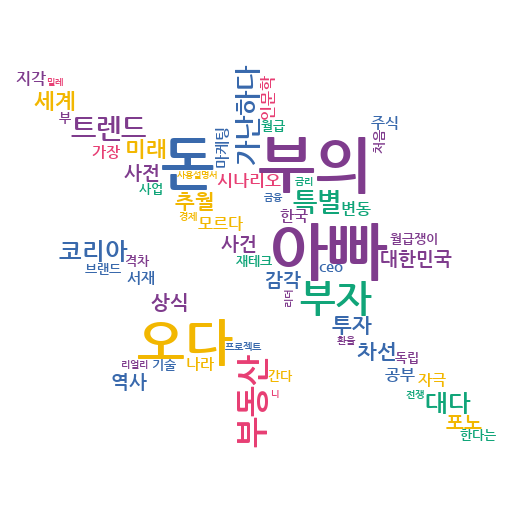

In [ ]:
pre_corona_eco = Counter()
pre_corona_eco_df = corpus[(corpus['코로나'] == '코로나 이전') & (corpus['분야'] == '경제/경영')]
pre_corona_eco_df['도서명'].apply(lambda row: pre_corona_eco.update(row));

stylecloud.gen_stylecloud(text=dict(pre_corona_eco.most_common(60)), icon_name="fas fa-virus-slash",
                          background_color='white',
                          font_path="C:\\Fonts\\NanumGothicBold.ttf",
                          output_name='pre_corona_eco.png')

Image("C:/Users/mono456/Desktop/Projects/새 폴더/pre_corona_eco.png")

# 4. 신간도서 중 베스트셀러가 되는 비율과 되기까지의 기간 or베스트셀러 키워드들이 신간도서에서 나타나는 시기 


In [ ]:
data = pd.read_excel('신간도서.xlsx')
del data['Unnamed: 0']
data['도서명'] = data['도서명'].apply(lambda row : str(row))
data.dropna(inplace=True)
data.head()

,도서명,분야,저자/역자,판형,면수,정가,출판사,ISBN,출판월
0,4차 산업 수업 혁명,총류,변문경 외著,規外,262,"₩25,000",다빈치books,9791186742280,201901
1,Angular Essentials,총류,이웅모著,規外,588,"₩32,000",루비페이퍼,9791186710340,201901
2,Core C Programming,총류,천정아著,規外,784,"₩28,000",연두에디션,9791188831166,201901
3,RxJS 퀵스타트,총류,손찬욱著,規外,440,"₩28,000",루비페이퍼,9791186710357,201901
4,The Python,총류,허진경著,規外,330,"₩25,000",부크크(주),9791127251765,201901


In [ ]:
data = data[~data['분야'].str.contains('기타|문학', regex=True)]

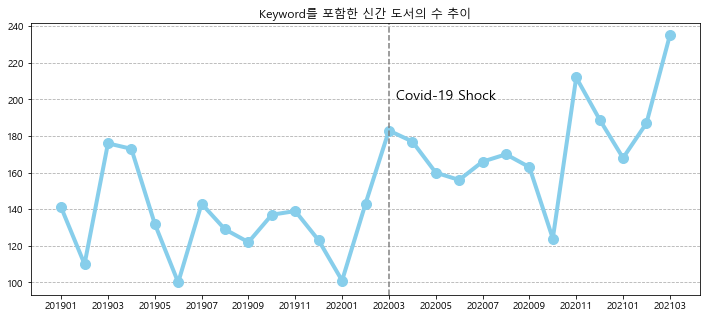

In [ ]:
keywords = ['미래', '투자', '주식', '비밀', '하버드', '심리학', '대화', '지식', '코로나', '돈',
            '재무제표', '인문학', '사랑', '인간관계', '회계사']
dates = [i for i in range(201901, 201913)] + [i for i in range(202001, 202013)] + [i for i in range(202101, 202104)]
temp_data = pd.DataFrame(index=dates)

for word in keywords:

    temp = data[data['도서명'].str.contains(word)].groupby('출판월')['도서명'].count()

    for i in dates:
    
        if i not in temp.index:
            temp[i] = 0
            
    temp = temp.sort_index()
    temp.index = temp.index
    temp.name = word
    temp_data = pd.concat([temp_data, temp], axis=1)
    
temp_data.index = temp_data.index.astype(str)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(temp_data.sum(axis=1), color='skyblue', lw=4, marker='o', ms=10)
ax.set_xticks(['201901', '201903', '201905', '201907', '201909', '201911', '202001', '202003', '202005', '202007', '202009',
                    '202011', '202101', '202103'])
ax.axvline('202003', ls='--', color='gray')
ax.text(14.3, 200, 'Covid-19 Shock', fontsize=14)
ax.grid(axis='y', ls='--');
ax.set_title('Keyword를 포함한 신간 도서의 수 추이');

In [ ]:
temp_data

,미래,투자,주식,비밀,하버드,심리학,대화,지식,코로나,돈,재무제표,인문학,사랑,인간관계,회계사
201901,21,32,10,9,3,10,6,5,0,11,0,10,23,0,1
201902,17,22,3,6,0,10,6,7,0,7,0,9,17,4,2
201903,28,14,9,12,1,30,12,14,0,8,1,13,27,6,1
201904,15,24,15,20,3,9,4,7,0,10,1,12,47,1,5
201905,15,35,4,17,1,14,4,4,0,5,0,2,28,1,2
201906,12,13,10,4,0,7,5,7,0,9,0,5,26,0,2
201907,22,17,6,9,2,19,3,10,0,14,1,5,31,2,2
201908,14,14,11,12,3,14,6,11,0,14,2,3,20,3,2
201909,18,12,3,11,3,9,8,10,0,10,0,6,16,7,9
201910,13,20,11,13,1,12,4,18,0,7,1,7,26,2,2


- 특정 분야에 대한 월별 신간 도서의 수

In [ ]:
data['분야'].unique()

array(['총류', '컴퓨터과학', '프로그래밍', '문헌정보학', '백과사전', '강연집 및 수필', '학회 및 기관지',
       '신물 및 저널리즘', '향토자료', '철학', '종교', '사회과학', '통계자료', '경제학',
       '사회학 및 사회문제', '행정학', '법률', '교육학', '풍습, 예절, 민속', '국방 및 군사', '자연과학',
       '기술과학', '의학', '농업', '공학 및 토목', '건축', '기계공학', '전기전자공학', '화학공학',
       '제조업', '생활과학', '예술', '비영어 언어', '영어', '역사', '도서학', '일반연속간행물',
       '일반 전집 및 총서', '지식 및 학문 일반', '이론 체계 및 시스템'], dtype=object)

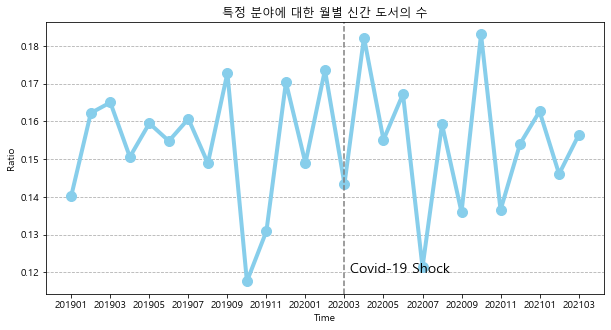

In [ ]:
temp = data[data['분야'].str.contains('사회과학|경제', regex=True)].groupby('출판월')['도서명'].count().to_frame()
temp = temp / data.groupby('출판월')['도서명'].count().to_frame()
temp.index = temp.index.astype(str)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(temp, color='skyblue', lw=4, marker='o', ms=10)

ax.set_xticks(['201901', '201903', '201905', '201907', '201909', '201911', '202001', '202003', '202005', '202007', '202009',
                    '202011', '202101', '202103'])

ax.axvline('202003', ls='--', color='gray')
ax.text(14.3, 0.12, 'Covid-19 Shock', fontsize=14)
ax.grid(axis='y', ls='--')
ax.set_title('특정 분야에 대한 월별 신간 도서의 수')
ax.set_xlabel('Time')
ax.set_ylabel('Ratio');

- 베스트 셀러 도서가 출간 이후 베스트 셀러에 도달하기까지 걸린 기간

In [ ]:
data = pd.read_excel('Best_Seller.xlsx')
data['작성연월'] = data['작성연월'].apply(lambda row : str(row))
data['가중치'] = data['가중치'].apply(lambda row : float(row))
data['출간일'] = data['출간일'].apply(lambda row : str(row))
print("총 Rows 수 : ", len(data))
del data['Unnamed: 0']
data.head()

총 Rows 수 :  5399


,순위,ISBN,도서명,저자명,출판사명,출간일,분야,정가,작성연월,코로나,가중치
0,1,9791187498384,고요할수록 밝아지는 것들,혜민 스님,수오서재,20181206,시/에세이,15000,201901,코로나 이전,7.243582
1,2,9788959895526,트렌드 코리아 2019,김난도,미래의창,20181026,경제/경영,17000,201901,코로나 이전,7.171863
2,3,9788984373617,아가씨와 밤,기욤 뮈소,밝은세상,20181126,소설,14500,201901,코로나 이전,7.100855
3,4,9791187119845,나는 나로 살기로 했다,김수현,마음의숲,20200316,시/에세이,13800,201901,코로나 이전,7.030549
4,5,9788925563350,"곰돌이 푸, 행복한 일은 매일 있어",곰돌이 푸 (원작),알에이치코리아,20180312,시/에세이,12000,201901,코로나 이전,6.960940


In [ ]:
temp = copy.deepcopy(data[data['출간일'] > '20190000']).drop_duplicates(['도서명'], keep='first')
temp['기간'] = temp[['출간일', '작성연월']].apply(lambda row : DIFF(row), axis=1)
print('베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(temp[temp['기간'] > 0]['기간'].mean(), 2), '일')


temp1 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이후')]['기간'] 

mean = temp1.mean()
print('코로나 이후 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(mean, 2), '일,', f'표본 : {len(temp1)} 개')


temp2 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이전')]['기간'] 

mean = temp2.mean()
print('코로나 이전 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(mean, 2), '일,', f'표본 : {len(temp2)} 개')

F = temp1.var() / temp2.var()
df1 = len(temp1) - 1; df2 = len(temp2)

print()
print("##분산의 동일성 검정##")
p_value = 1 - stats.f.cdf(F, df1, df2)
print('분산의 동일성의 p-value :', round(p_value, 4)) #이분산

print()
print('##평균의 동일성 검점##')
print("코로나 전후의 베스트 셀러가 되기까지의 기간의 동일성 검정의 p-value : ", 
       round(stats.ttest_ind(temp1, temp2, equal_var=False)[1], 4)) #8% 유의수준에서 동일하지 않다.

베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  27.64 일
코로나 이후 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  30.36 일, 표본 : 517 개
코로나 이전 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  24.79 일, 표본 : 494 개

##분산의 동일성 검정##
분산의 동일성의 p-value : 0.0

##평균의 동일성 검점##
코로나 전후의 베스트 셀러가 되기까지의 기간의 동일성 검정의 p-value :  0.0791


In [ ]:
temp1 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이전')].drop_duplicates(['도서명'])
temp1 = temp1.groupby('분야')['기간'].agg(['mean', 'count'])
temp1 = temp1[temp1['count'] > 15]

temp2 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이후')].drop_duplicates(['도서명'])
temp2 = temp2.groupby('분야')['기간'].agg(['mean', 'count'])
temp2 = temp2.loc[list(temp1.index)]

means_before_after_covid = pd.concat([temp1, temp2], axis=1)
means_before_after_covid.columns = ['Before Mean', 'Count', 'After Mean', 'Count' ]
means_before_after_covid


temp = temp[temp['기간'] > 0].drop_duplicates(['도서명'], keep='first')

min_diff_p_value = pd.Series(dtype=float)
for idx in means_before_after_covid.index:
    temp1 = temp[(temp['분야'] == idx) & (temp['코로나'] == '코로나 이전')]['기간']
    temp2 = temp[(temp['분야'] == idx) & (temp['코로나'] == '코로나 이후')]['기간']
    
    ##F-test
    F = temp1.var() / temp2.var()
    df1 = len(temp1); df2 = len(temp2)
    p_value = 1 - stats.f.cdf(F, df1, df2)
    if p_value < 0.05:
        result = stats.ttest_ind(temp1, temp2, equal_var=False)[1]
    else:
        result = stats.ttest_ind(temp1, temp2, equal_var=True)[1]
        
    min_diff_p_value[idx] = result
        
means_before_after_covid['p-value'] = min_diff_p_value
means_before_after_covid['Mean Equality'] = means_before_after_covid['p-value'] > 0.1
means_before_after_covid

,Before Mean,Count,After Mean,Count,p-value,Mean Equality
분야,,,,,,
경제/경영,23.036585,82,27.536364,110,0.571540,True
만화,15.043478,23,45.470588,17,0.255030,True
소설,25.833333,54,29.365385,52,0.708846,True
시/에세이,20.632353,68,29.209677,62,0.118114,True
어린이(초등),26.938462,65,18.392857,56,0.062679,False
인문,18.170732,41,19.673913,46,0.519830,True
자기계발,22.240741,54,36.600000,55,0.255097,True
정치/사회,20.900000,20,28.074074,27,0.421305,True


- 신간 도서가 베스트 셀러가 되기까지 걸린 시간

In [ ]:
data = pd.read_excel('신간도서.xlsx')
del data['Unnamed: 0']
data['도서명'] = data['도서명'].apply(lambda row : str(row))
data.dropna(inplace=True)
data.head()

,도서명,분야,저자/역자,판형,면수,정가,출판사,ISBN,출판월
0,4차 산업 수업 혁명,총류,변문경 외著,規外,262,"₩25,000",다빈치books,9791186742280,201901
1,Angular Essentials,총류,이웅모著,規外,588,"₩32,000",루비페이퍼,9791186710340,201901
2,Core C Programming,총류,천정아著,規外,784,"₩28,000",연두에디션,9791188831166,201901
3,RxJS 퀵스타트,총류,손찬욱著,規外,440,"₩28,000",루비페이퍼,9791186710357,201901
4,The Python,총류,허진경著,規外,330,"₩25,000",부크크(주),9791127251765,201901


In [ ]:
data1 = pd.read_excel('Best_Seller.xlsx')
data1['작성연월'] = data1['작성연월'].apply(lambda row : str(row))
data1['가중치'] = data1['가중치'].apply(lambda row : float(row))
data1['출간일'] = data1['출간일'].apply(lambda row : str(row))
del data1['Unnamed: 0']

In [ ]:
mask = data1['도서명'].apply(lambda row : DIFF1(row, data))

In [ ]:
new_data = data1[mask].drop_duplicates(['도서명'], keep='first')
new_data = new_data[new_data['출간일'] > '20190000'].drop_duplicates(['도서명'], keep='first')
new_data.head()

,순위,ISBN,도서명,저자명,출판사명,출간일,분야,정가,작성연월,코로나,가중치
53,54,9788965707462,"사랑하게 해줘서, 고마워",김재식,쌤앤파커스,20190103,시/에세이,14000,201901,코로나 이전,4.274847
60,61,9791187481485,온라인 쇼핑의 종말,바이난트 용건,지식노마드,20190104,경제/경영,20000,201901,코로나 이전,3.987227
73,74,9788972916802,호킹의 빅 퀘스천에 대한 간결한 대답,스티븐 호킹,까치,20190107,과학,17000,201901,코로나 이전,3.503427
87,88,9791195855391,책쓰기가 이렇게 쉬울 줄이야,양원근,오렌지연필,20190104,인문,14000,201901,코로나 이전,3.047852
91,92,9791189089580,노마드 비즈니스맨,이승준,라온북,20190125,자기계발,15000,201901,코로나 이전,2.928926


In [ ]:
temp = copy.deepcopy(new_data)
temp['기간'] = temp[['출간일', '작성연월']].apply(lambda row : DIFF(row), axis=1)
print('베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(temp[temp['기간'] > 0]['기간'].mean(), 2), '일')


temp1 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이후')]['기간'] 

mean = temp1.mean()
print('코로나 이후 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(mean, 2), '일,', f'표본 : {len(temp1)} 개')


temp2 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이전')]['기간'] 

mean = temp2.mean()
print('코로나 이전 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 : ', 
      round(mean, 2), '일,', f'표본 : {len(temp2)} 개')

F = temp1.var() / temp2.var()
df1 = len(temp1) - 1; df2 = len(temp2)

print()
print("##분산의 동일성 검정##")
p_value = 1 - stats.f.cdf(F, df1, df2)
print('분산의 동일성의 p-value :', round(p_value, 4)) #이분산

print()
print('##평균의 동일성 검점##')
print("코로나 전후의 베스트 셀러가 되기까지의 기간의 동일성 검정의 p-value : ", 
       round(stats.ttest_ind(temp1, temp2, equal_var=False)[1], 4)) #10% 유의수준에서 동일하지 않다.

베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  27.56 일
코로나 이후 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  31.59 일, 표본 : 227 개
코로나 이전 베스트 셀러 도서가 출간 이후 베스트 셀러가 되기까지의 평균 기간 :  23.5 일, 표본 : 225 개

##분산의 동일성 검정##
분산의 동일성의 p-value : 0.0

##평균의 동일성 검점##
코로나 전후의 베스트 셀러가 되기까지의 기간의 동일성 검정의 p-value :  0.0909


In [ ]:
temp1 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이전')].drop_duplicates(['도서명'])
temp1 = temp1.groupby('분야')['기간'].agg(['mean', 'count'])
temp1 = temp1[temp1['count'] > 10]

temp2 = temp[(temp['기간'] > 0) & (temp['코로나'] == '코로나 이후')].drop_duplicates(['도서명'])
temp2 = temp2.groupby('분야')['기간'].agg(['mean', 'count'])
temp2 = temp2.loc[list(temp1.index)]

means_before_after_covid = pd.concat([temp1, temp2], axis=1)
means_before_after_covid.columns = ['Before Mean', 'Count', 'After Mean', 'Count' ]
means_before_after_covid


temp = temp[temp['기간'] > 0].drop_duplicates(['도서명'], keep='first')

min_diff_p_value = pd.Series(dtype=float)
for idx in means_before_after_covid.index:
    temp1 = temp[(temp['분야'] == idx) & (temp['코로나'] == '코로나 이전')]['기간']
    temp2 = temp[(temp['분야'] == idx) & (temp['코로나'] == '코로나 이후')]['기간']
    
    ##F-test
    F = temp1.var() / temp2.var()
    df1 = len(temp1); df2 = len(temp2)
    p_value = 1 - stats.f.cdf(F, df1, df2)
    if p_value < 0.05:
        result = stats.ttest_ind(temp1, temp2, equal_var=False)[1]
    else:
        result = stats.ttest_ind(temp1, temp2, equal_var=True)[1]
        
    min_diff_p_value[idx] = result
        
means_before_after_covid['p-value'] = min_diff_p_value
means_before_after_covid['Mean Equality'] = means_before_after_covid['p-value'] > 0.1
means_before_after_covid

,Before Mean,Count,After Mean,Count,p-value,Mean Equality
분야,,,,,,
경제/경영,26.098039,51,30.052632,57,0.770964,True
소설,31.428571,21,43.764706,17,0.581887,True
시/에세이,20.045455,44,30.842105,38,0.198117,True
인문,19.818182,22,18.562500,32,0.611757,True
자기계발,21.179487,39,25.862069,29,0.397275,True
